#Using detectron to detect cars

In [10]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
# !conda install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
# !conda install cython pyyaml==5.1
# !conda install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.4.0 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 667kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post200513-cp36-none-any.whl size=40893 sha256=ccce0749357d25eed53b699afc0c06743b12101b2967ed43bb67f1dea1282b89
  Stored in directory: /root/.cache/pip/wheels/a2/f6/77/551770c4b8cd75e9335cd0acf59c08d60a8684048b19da6702
Successfully built fvcore


In [11]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import os
import glob

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

ModuleNotFoundError: No module named 'cv2'

## Get an image from local test dir


> Everytime session restarts - create test/Car/ in Content dir


> Upload the test images to dir







In [2]:
path = 'test/Car'
im = cv2.imread(path+"/ac2f96661ce3c3db.jpg")
cv2_imshow(im)

NameError: name 'cv2' is not defined

## Create detectron configuration and prediction to make inference

In [4]:
cfg = get_cfg()
# Go to model_zoo and choose a config file for a model - Go to GitHub
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
# outputs = predictor(im)

model_final_68b088.pkl: 421MB [00:41, 10.2MB/s]                           


In [ ]:
# Look at output from model
# shows the object classes from output
outputs["instances"].pred_classes
# shows bounding box for the detected classes
outputs["instances"].pred_boxes

## Visualize predictions in image


In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
cv2.imwrite('predictedEx.jpg', v.get_image()[:, :, ::-1]) 

## Remove classes of no interest

In [5]:
# outputs: dict{
#             Instances (class)
#                   pred_box: bbox for every instance tensor(num_instance, 4)
#                   scores: score for each class instance (0,1)
#                   pred_class: tensor of predicted classes
# }

# 1. Make variable reference to output 
img_size = outputs["instances"].image_size
cls = outputs["instances"].pred_classes
scores = outputs['instances'].scores
boxes = outputs['instances'].pred_boxes

# 2. Remove non-car classes - car class = 2?
# flatten tensor to list
cls_to_list = cls.flatten().tolist()
# list comprehension to build list with index where value != 2
indx_to_remove = [ind if val!=2 else None for (ind, val) in enumerate(cls_to_list)]
# filter None and return list
indx_to_remove = list(filter(lambda x: isinstance(x, int), indx_to_remove))
indx_to_remove

# 3. Delete corresponding arrays
cls = np.delete(cls.cpu().numpy(), indx_to_remove)
scores = np.delete(scores.cpu().numpy(), indx_to_remove)
# WORKAROUND for numpy.ndarray - loops through boxes.tensor and remove tensor 
# index-wise, stack bbox tensors back into one tensor
car_boxes = []
for ind, tensor in enumerate(boxes.tensor):
  if ind not in indx_to_remove:
    car_boxes.append(tensor)
  else: continue

car_box_tensor = torch.stack(car_boxes)
# car_box_tensor
print(cls, scores, car_boxes)



NameError: ignored

In [ ]:

# car_boxes
cls
for instance in scores:
  print(instance)

torch.tensor([[1,2,3,45,6],[1,23,3,45,6]])
car_box_tensor.tolist()

# Loop through all jpg files to make prediction
cls - np.array([class, class, ...])

scores - np.array([class_score, class_score, ...])

car_box_tensor - tensor([[x,y,w,h], [x,y,w,h], ...])

Processing: 1/136 test/Car/da546a4af380b650.jpg


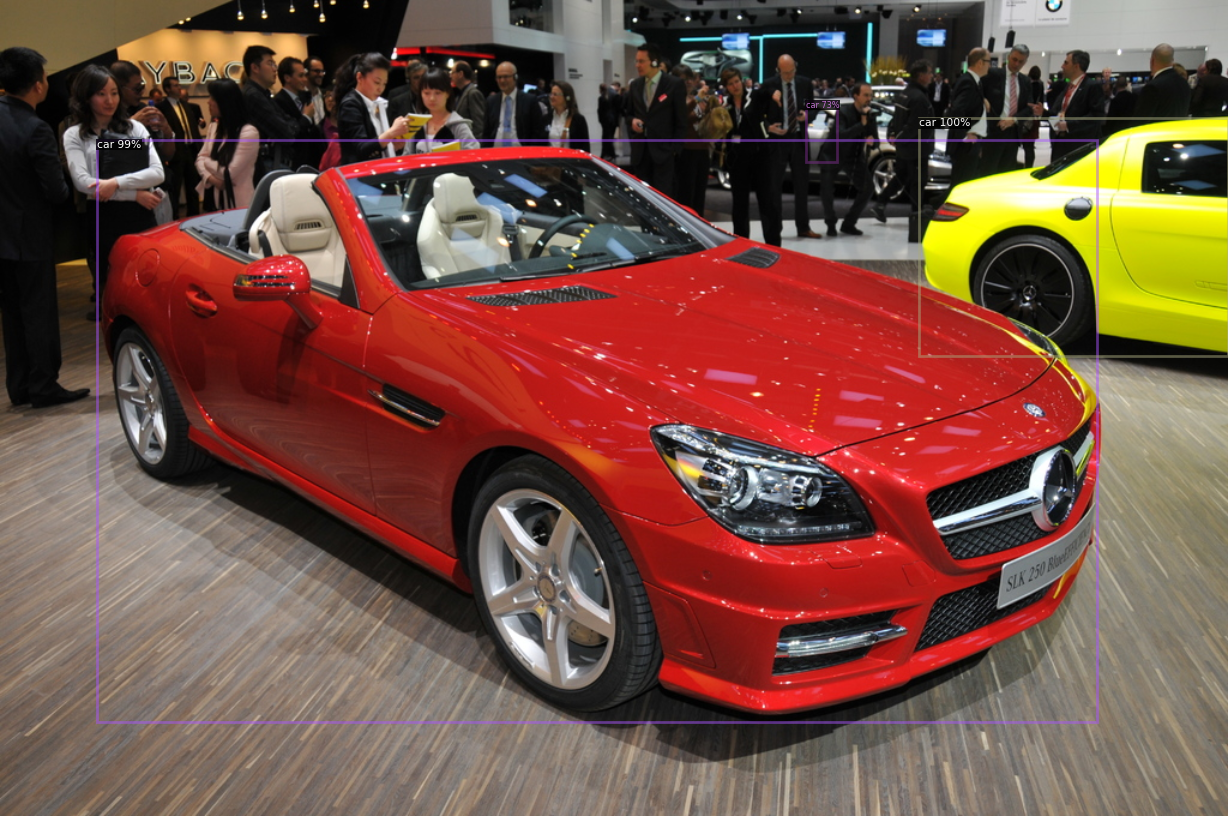

Processing: 2/136 test/Car/0012b7a8cd7c48d2.jpg


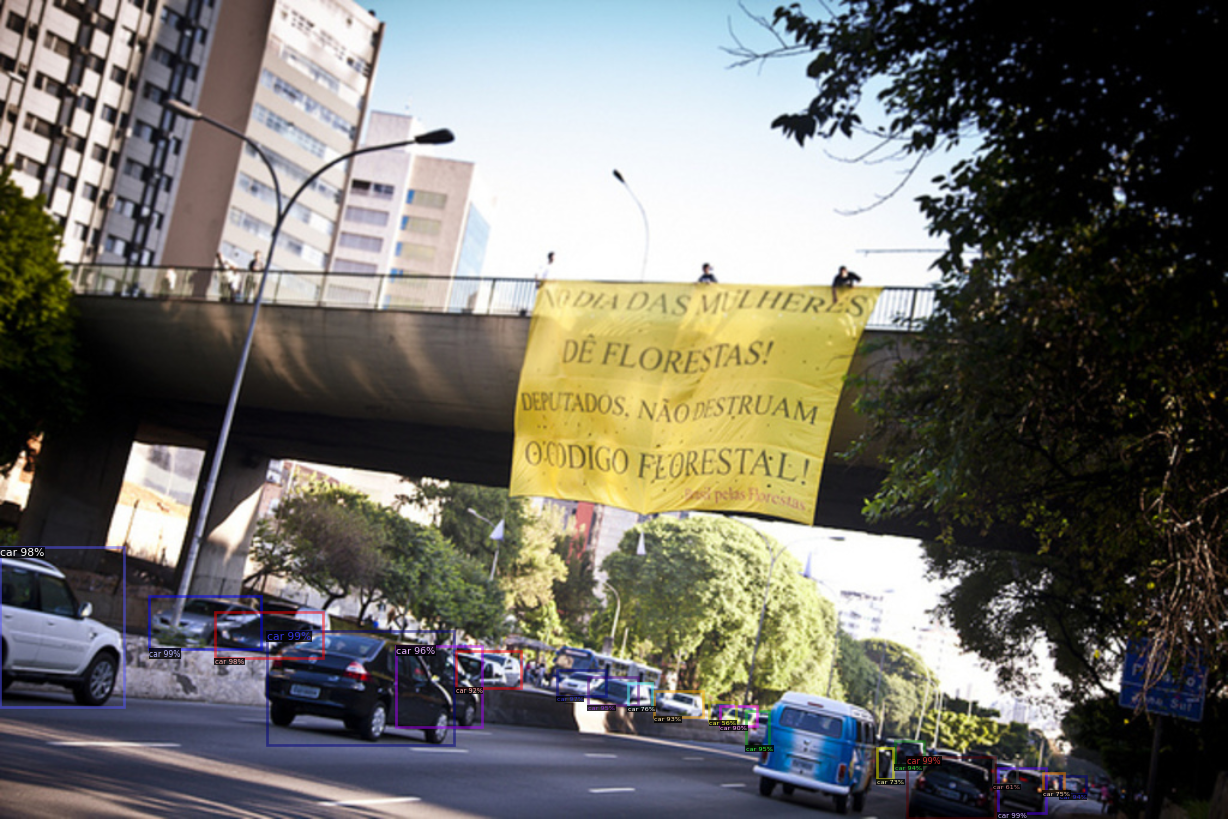

Processing: 3/136 test/Car/acfa59452a595526.jpg


In [ ]:
path = 'test/Car'
dst_path = 'output/Car'
rows_list = []
no_car = []
count = 1

for jpgfile in glob.iglob(os.path.join(path, "*.jpg")):
  
  print('Processing: %s/136'%count, jpgfile)
  count += 1
  
  # jpgfile = test/Car/000765..enc.jpg
  imgEncoding = jpgfile.split('.')[0].split('/')[-1]
  class_name = 'Car'

  # make inference
  im = cv2.imread(jpgfile)
  outputs = predictor(im)

  img_size = outputs["instances"].image_size
  cls = outputs["instances"].pred_classes
  scores = outputs['instances'].scores
  boxes = outputs['instances'].pred_boxes


  # 2. Remove non-car classes - car class = 2
  # flatten tensor to list
  cls_to_list = cls.flatten().tolist()
  # list comprehension to build list with index where value != 2
  indx_to_remove = [ind if val!=2 else None for (ind, val) in enumerate(cls_to_list)]
  # filter None and return list
  indx_to_remove = list(filter(lambda x: isinstance(x, int), indx_to_remove))
  

  # 3. Delete corresponding arrays
  cls = np.delete(cls.cpu().numpy(), indx_to_remove)
  scores = np.delete(scores.cpu().numpy(), indx_to_remove)
  # WORKAROUND for numpy.ndarray - loops through boxes.tensor and remove tensor 
  # index-wise, stack bbox tensors back into one tensor
  car_boxes = []
  # for-loop to construct detected car bbox tensors 
  for ind, tensor in enumerate(boxes.tensor):
    if ind not in indx_to_remove:
      car_boxes.append(tensor)
    else: continue

  # in case model did not detect a vehicle in the image
  try:
    car_box_tensor = torch.stack(car_boxes)
    bbox_list = car_box_tensor.tolist()

    # for-loop to save imgsize, cls, scores, bbox instances 
    for ind, instance in enumerate(cls):
      bbox = bbox_list[ind]
      x, y, w, h = bbox
      
      row_dict = {
        'imgPath': jpgfile,
        'imgEncode': imgEncoding,
        'class': class_name,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
      }

      rows_list.append(row_dict)

    # 4. Convert back to tensor and move to cuda
    # cls = cls.clone().detach().to('cuda:0')
    # scores = scores.clone().detach().to('cuda:0')
    cls = torch.tensor(cls).to('cuda:0')
    scores = torch.tensor(scores).to('cuda:0')
    boxes.tensor = car_box_tensor

    # 5. Create new instance object and set its fields
    obj = detectron2.structures.Instances(image_size=img_size)
    obj.set('pred_classes', cls)
    obj.set('scores', scores)
    obj.set('pred_boxes', boxes)

    newInstance = {'instances': obj}

    # 6. Use `Visualizer` to draw the predictions on the image.
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(newInstance["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    cv2.imwrite(os.path.join(dst_path, imgEncoding+'.jpg'), v.get_image()[:, :, ::-1])

  # RuntimeError when torch.stack fail to stack empty car_box_tensor array
  except RuntimeError:
    no_car.append(imgEncoding)
    row_dict = {
        'imgPath': jpgfile,
        'imgEncode': imgEncoding,
        'class': class_name,
        'x': None,
        'y': None,
        'w': None,
        'h': None,
    }

    rows_list.append(row_dict)

columns = ['imgPath', 'imgEncode', 'class', 'x', 'y', 'w', 'h']
pred_table = pd.DataFrame(data=rows_list, columns=columns)
pred_table.to_csv('pred_carBBox.csv', index=True)
pred_table.head

    






In [ ]:

# 4. Convert back to tensor and move to cuda
# cls = cls.clone().detach().to('cuda:0')
# scores = scores.clone().detach().to('cuda:0')
cls = torch.tensor(cls).to('cuda:0')
scores = torch.tensor(scores).to('cuda:0')
boxes.tensor = car_box_tensor

# 5. Create new instance object and set its fields
obj = detectron2.structures.Instances(image_size=img_size)
obj.set('pred_classes', cls)
obj.set('scores', scores)
obj.set('pred_boxes', boxes)

newInstance = {'instances': obj}
# outputs
# obj

## Visualize prediction with only class Car

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(newInstance["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
cv2.imwrite('carPredictEx.jpg', v.get_image()[:, :, ::-1]) 